# Assignment: Application Classification

This assignment will focus on feature extraction, ML modeling, evaluation, and explainability. You will do this in the context of application classification.

**Submission Instructions**: 
- You should submit a single notebook containing your code to extract features and model evaluation, and response to Part 3.
- You should assume the CSVs are located in a folder called `data`, co-located with the notebook.
- Make sure the notebook is styled well. Write code in the relevant sections of the notebook. 
- I should be able to run the entire notebook without any errors. 

In [ ]:
"""
SUBMITTED ON: 2025-04-23
AUTHOR: Manish Kumar, Pratham Agarwal

DESCRIPTION: 
The following .ipynb notebook includes functions for data cleaning, transformation, and visualization for classification done on ISCX VPN-nonVPN dataset.


RESULTS:
Accuracy: 
0.92      (simple RF)
0.91      (RF with 10 fold cross-validation)

"""

## Dataset download and Warmup

We will use a public dataset, called [ISCXVPN2016](https://www.unb.ca/cic/datasets/vpn.html) that consists of annotated traffic logs. While the original dataset is available in the form of PCAPs, I have also shared the CSV files extracted from the PCAPs, available on [Onedrive](https://csciitd-my.sharepoint.com/:f:/g/personal/tmangla_iitd_ac_in/Ev5JYDW-YI5CjKq3XWgL0y8BdihJTCi4v4qA5Sn1UoKisQ?e=INZ5mJ). The data consists of TSV (tab-seprated) files with each file corresponding to a different application. Each row in the file corresponds to one packet for that application. The headers follow this schema: 
```
columns = ["frame.time_epoch", "frame.len", "ip.src", "ip.dst", "ip.proto",
    "udp.srcport", "udp.dstport", "tcp.srcport", "tcp.dstport",
    "tcp.flags", "tcp.flags.syn", "tcp.flags.fin", "dns.qry.name"]
```

**Getting application ground truth:** You can use the filename of the CSV file

Download the dataset and read it. You can read the data in a dataframe: 
```
df = pd.read_csv(filename, sep="\t", header=None, names=columns)
```

In [ ]:
# Installing Reqd. Packages
! pip install pandas numpy matplotlib seaborn scikit-learn

In [1]:
# Importing Libraries
import os
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
#--------------CONSTANTS-----------------
DATA_PATH = "data"
RESULTS_DIR = "results"
GROUPED_JSON_FILE = os.path.join(RESULTS_DIR, "grouped_classes.json")
OUTPUT_FLOWS_FILE = os.path.join(RESULTS_DIR, "flows.csv")
UDP_TIMEOUT = 30            # seconds, can be adjusted

In [3]:
def group_files_by_class(folder_path):
    """
    Groups files in the specified folder by class name.
    """
    
    print(f"Grouping files in folder: {folder_path}")
    files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]              # Get list of all CSV files
    if not files:
        print("No CSV files found in the specified folder.")
        return

    grouped_files = defaultdict(list)                                               # Dictionary to hold grouped files

    for file in files:
        # Extract the class name before '_capture'
        class_name = '_'.join(file.split('_')[:2])                                  # vpn_skype-chat or nonvpn_rdp, etc.
        grouped_files[class_name].append(file)

    # Print grouped classes
    # for class_name, file_list in grouped_files.items():
        # print(f"\nClass: {class_name}")
        # for file in file_list:
            # print(f"  - {file}")

    # Save groupings to JSON file
    with open(GROUPED_JSON_FILE, 'w') as f:
        json.dump(grouped_files, f, indent=4)

    print(f"Grouped classes saved to '{GROUPED_JSON_FILE}'")
    return grouped_files

In [4]:
def get_bidirectional_key(src_ip, src_port, dst_ip, dst_port, protocol):
    """
    Returns a bidirectional key for the connection. {sets lower IP/port first}
    """
    
    if (src_ip, src_port) <= (dst_ip, dst_port):
        return (src_ip, src_port, dst_ip, dst_port, protocol)
    else:
        return (dst_ip, dst_port, src_ip, src_port, protocol)

In [5]:
def process_files(grouped_files, folder_path, output_file):
    """
    Processes files in the specified folder and extracts flows.
    """
    
    flow_index = 1
    all_flows = []
    total_flows = 0
    
    # Iterate through each class and its corresponding files
    for label, files in grouped_files.items():
        # Initialize a dictionary to hold flow data
        # Each flow is defined by 5-tuple (src_ip, src_port, dst_ip, dst_port, protocol)
        flows = defaultdict(lambda: {
            "timestamps": [], "sizes": [], "directions": [],
            "label": label, "last_ts": None, "proto": None,
            "first_seen": None, "syn_seen": False, "initiator": None
        })

        for index, file in enumerate(files):
            file_path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(file_path, sep='\t', header=None, names=[
                    "frame.time_epoch", "frame.len", "ip.src", "ip.dst", "ip.proto",
                    "udp.srcport", "udp.dstport", "tcp.srcport", "tcp.dstport",
                    "tcp.flags", "tcp.flags.syn", "tcp.flags.fin", 
                    "dns.qry.name"], dtype={4:str, 12: str})

                print(f"[{index + 1:02}/{len(files):02}] Processing file: {os.path.basename(file_path)}")
                # print("Initial packets:", len(df))

                # Drop rows with missing frame.len, ip.src or ip.dst
                df = df.dropna(subset=["frame.len", "ip.src", "ip.dst"])
                # print(len(df), "packets after dropping NaN values")
                
                # Also, ensure that ip.proto is numeric
                df = df[df["ip.proto"].str.match(r"^\d+$", na=False)]
                df["ip.proto"] = df["ip.proto"].astype(int)        
                # print(len(df), "packets after filtering for numeric ip.proto")

                # Filter for TCP and UDP packets only
                df = df[(df["ip.proto"] == 6) | (df["ip.proto"] == 17)]
                # print(len(df), "packets after filtering for TCP/UDP")

                # Also, filter out DNS queries (where dns.qry.name is not NaN)
                df = df[df["dns.qry.name"].isna()]
                # print(len(df), "packets after filtering out DNS queries")

                # Convert relevant columns to appropriate types
                df["frame.time_epoch"] = df["frame.time_epoch"].astype(float)
                df["frame.len"] = df["frame.len"].astype(int)

                # print(f"Class: {label}, Number of packets: {len(df)}")

                # Iterate through the DataFrame rows to extract flow data
                # For each packet, check if it's TCP or UDP and process accordingly
                for _, row in df.iterrows():
                    ts = row["frame.time_epoch"]
                    size = row["frame.len"]
                    proto = row["ip.proto"]
                    src_ip = row["ip.src"]
                    dst_ip = row["ip.dst"]
                    direction = None                # 1 for src->dst, 0 for dst->src

                    if proto == 6:  # TCP
                        sport = int(row["tcp.srcport"]) if pd.notna(row["tcp.srcport"]) else 0
                        dport = int(row["tcp.dstport"]) if pd.notna(row["tcp.dstport"]) else 0
                        syn_flag = str(row["tcp.flags.syn"]).strip() == '1'
                        fin_flag = str(row["tcp.flags.fin"]).strip() == '1'

                        # Get the connection key for bidirectional flow
                        # and determine the direction based on IP/port values
                        conn_key = get_bidirectional_key(src_ip, sport, dst_ip, dport, "TCP")

                        # Initialize flow on first sight
                        flow = flows[conn_key]
                        flow["proto"] = "TCP"
                        if flow["first_seen"] is None:
                            flow["first_seen"] = ts
                            if syn_flag:
                                flow["initiator"] = (src_ip, sport)             # src_ip, sport is the initiator of the connection

                        # Set dir. for the packet
                        if flow["initiator"]:
                            direction = 1 if (src_ip, sport) == flow["initiator"] else 0
                        else:
                            direction = 1 if (src_ip, sport) < (dst_ip, dport) else 0

                        # Append the current packet to the flow
                        flow["timestamps"].append(ts)
                        flow["sizes"].append(size)
                        flow["directions"].append(direction)

                        # Close the flow if FIN flag is set
                        if fin_flag:
                            all_flows.append({
                                "index": flow_index,
                                "connection": conn_key,
                                "timestamps": flow["timestamps"],
                                "sizes": flow["sizes"],
                                "directions": flow["directions"],
                                "label": flow["label"]
                            })
                            flow_index += 1
                            del flows[conn_key]  # Remove the flow from the dictionary

                    elif proto == 17:  # UDP
                        sport = int(row["udp.srcport"]) if pd.notna(row["udp.srcport"]) else 0
                        dport = int(row["udp.dstport"]) if pd.notna(row["udp.dstport"]) else 0

                        conn_key = get_bidirectional_key(src_ip, sport, dst_ip, dport, "UDP")
                        flow = flows[conn_key]

                        if flow["first_seen"] is None:
                            flow["first_seen"] = ts
                            flow["initiator"] = (src_ip, sport)
                        flow["proto"] = "UDP"
                        
                        # Check if the flow has been inactive for more than UDP_TIMEOUT seconds or there exists a previous packet for this connection
                        # If so, close the flow and save it to all_flows
                        last_ts = flow["last_ts"]
                        if last_ts is not None and ts - last_ts > UDP_TIMEOUT:
                            all_flows.append({
                                "index": flow_index,
                                "connection": conn_key,
                                "timestamps": flow["timestamps"],
                                "sizes": flow["sizes"],
                                "directions": flow["directions"],
                                "label": flow["label"]
                            })
                            flow_index += 1

                            # Start a new flow after closing the old one
                            flows[conn_key] = {
                                "timestamps": [],
                                "sizes": [],
                                "directions": [],
                                "label": label,
                                "last_ts": ts,
                                "proto": "UDP",
                                "first_seen": ts,
                                "initiator": (src_ip, sport)
                            }

                        # Append the current packet to the flow
                        direction = 1 if (src_ip, sport) == flow["initiator"] else 0
                        flow["timestamps"].append(ts)
                        flow["sizes"].append(size)
                        flow["directions"].append(direction)
                        
                        # Update the last timestamp for the flow
                        # used to check for inactivity in the next iteration
                        flow["last_ts"] = ts if flow["last_ts"] is None else max(flow["last_ts"], ts)

            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

        # After all files of a class are processed, flush remaining flows
        for conn_key, flow_data in flows.items():
            all_flows.append({
                "index": flow_index,
                "connection": conn_key,
                "timestamps": flow_data["timestamps"],
                "sizes": flow_data["sizes"],
                "directions": flow_data["directions"],
                "label": flow_data["label"]
            })
            flow_index += 1 

        # Save flows from this file
        total_flows += len(all_flows)
        df_flows = pd.DataFrame(all_flows)
        write_header = not os.path.exists(output_file)
        df_flows.to_csv(output_file, mode='a', header=write_header, index=False)
    
        print(f"#Flows for class '{label}': {len(all_flows)}\n")
        all_flows.clear()  # Clear the list for the next class


    print(f"\n\nProcessed and found {total_flows} flows.")
    print(f"Flow data saved to '{output_file}'")

In [6]:
# Check if output_dir exists!
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# Check if grouped_classes.json already exists, 
# if so, load it into dictionary else compute it
if os.path.exists(GROUPED_JSON_FILE):
    with open(GROUPED_JSON_FILE, 'r') as f:
        grouped_files = json.load(f)
    print(f"Loaded existing groupings from '{GROUPED_JSON_FILE}'")
else:
    # If the file doesn't exist, compute the groupings
    print(f"'{GROUPED_JSON_FILE}' not found. Computing groupings for dir.: {DATA_PATH}")
    grouped_files = group_files_by_class(DATA_PATH)

'results\grouped_classes.json' not found. Computing groupings for dir.: data
Grouping files in folder: data
Grouped classes saved to 'results\grouped_classes.json'


In [7]:
# Print all classes(20) in the dataset
print("Classes:", list(grouped_files.keys()))

Classes: ['nonvpn_netflix', 'nonvpn_rdp', 'nonvpn_rsync', 'nonvpn_scp', 'nonvpn_sftp', 'nonvpn_skype-chat', 'nonvpn_ssh', 'nonvpn_vimeo', 'nonvpn_voip', 'nonvpn_youtube', 'vpn_netflix', 'vpn_rdp', 'vpn_rsync', 'vpn_scp', 'vpn_sftp', 'vpn_skype-chat', 'vpn_ssh', 'vpn_vimeo', 'vpn_voip', 'vpn_youtube']


In [ ]:
# Now, compute flows from the grouped files or load them from the existing file
if not os.path.exists(OUTPUT_FLOWS_FILE):
    print(f"\n'{OUTPUT_FLOWS_FILE}' not found. Extracting flows from files.")
    process_files(grouped_files, DATA_PATH, OUTPUT_FLOWS_FILE)
    flows = pd.read_csv(OUTPUT_FLOWS_FILE)
else:
    print(f"\n'{OUTPUT_FLOWS_FILE}' already exists. Skipping flow extraction.")
    flows = pd.read_csv(OUTPUT_FLOWS_FILE)
    print(f"Loaded {len(flows)} flows from '{OUTPUT_FLOWS_FILE}'")


'results\flows.csv' not found. Extracting flows from files.
[01/02] Processing file: nonvpn_netflix_capture1.csv
[02/02] Processing file: nonvpn_netflix_capture2.csv
#Flows for class 'nonvpn_netflix': 173

[01/05] Processing file: nonvpn_rdp_capture1.csv
[02/05] Processing file: nonvpn_rdp_capture2.csv
[03/05] Processing file: nonvpn_rdp_capture3.csv
[04/05] Processing file: nonvpn_rdp_capture4.csv
[05/05] Processing file: nonvpn_rdp_capture_5.csv
#Flows for class 'nonvpn_rdp': 31

[01/02] Processing file: nonvpn_rsync_capture1.csv
[02/02] Processing file: nonvpn_rsync_newcapture1.csv
#Flows for class 'nonvpn_rsync': 109

[01/03] Processing file: nonvpn_scp_capture1.csv
[02/03] Processing file: nonvpn_scp_long_capture1.csv
[03/03] Processing file: nonvpn_scp_newcapture1.csv
#Flows for class 'nonvpn_scp': 473

[01/05] Processing file: nonvpn_sftp_capture1.csv
[02/05] Processing file: nonvpn_sftp_capture2.csv
[03/05] Processing file: nonvpn_sftp_capture3.csv
[04/05] Processing file: non

In [13]:
print("\nFlow data columns and their datatypes: ")
print(flows.info())


Flow data columns and their datatypes: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4310 entries, 0 to 4309
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4310 non-null   int64 
 1   connection  4310 non-null   object
 2   timestamps  4310 non-null   object
 3   sizes       4310 non-null   object
 4   directions  4310 non-null   object
 5   label       4310 non-null   object
dtypes: int64(1), object(5)
memory usage: 202.2+ KB
None


## Part 1: Extracting Features

### Data cleaning

Extract the following features from the dataset: 
- Flow-level (5 features): flow duration, volume (upstream and downstream), number of packets (upstream and downstream)
- Packet-level features (36 features): Statistics on packet inter-arrival times and packet size. These need to be computed for both upstream and downstream direction. You should compute the following statistics for each flow: mean, median, std, min, max, quantiles (25%ile, 75%iles), and deciles (10%ile, 90%ile). Compute these statistics per feature (IAT, size) and direction (upstream, downstream).

**Defining Flows**: For TCP, a flow is same as connection (determined using SYN/FIN packets). You should define UDP flows using inactivity timeout, i.e., mark the end of the flow if you don't see a packet for T seconds. Use a reasonable value of T. 

Make sure you filter out the non-IP traffic as well as the DNS traffic from the data.

**Checkpoint**: Once you do that, summarize the number of flows for each application. You can extract the application name from the file name. VPN and non-VPN applications should be treated differently. You can remove classes with less than 10 instances for the next part. 

In [14]:
def get_IAT(timestamps):
    """
    Calculate Inter-Arrival Time (IAT) from a list of timestamps.
    """
    if len(timestamps) < 2:
        return []
    return [t2 - t1 for t1, t2 in zip(timestamps[:-1], timestamps[1:])]

In [15]:
def compute_stats(prefix, values):
    """Compute statistical features for a given list of values."""
    if not values:
        return {f"{prefix} {stat}": 0 for stat in [
            "Mean", "Median", "Std", "Min", "Max",
            "25%ile", "75%ile", "10%ile", "90%ile"
        ]}

    return {
        f"{prefix} Mean": np.mean(values),
        f"{prefix} Median": np.median(values),
        f"{prefix} Std": np.std(values) if len(values) > 1 else 0,
        f"{prefix} Min": np.min(values),
        f"{prefix} Max": np.max(values),
        f"{prefix} 25%ile": np.percentile(values, 25),
        f"{prefix} 75%ile": np.percentile(values, 75),
        f"{prefix} 10%ile": np.percentile(values, 10),
        f"{prefix} 90%ile": np.percentile(values, 90),
    }

In [16]:
def compute_flow_features(df):
    """
    Compute flow-level features from the DataFrame.
    """
    flow_features = []

    for _, row in df.iterrows():
        ts_list = eval(row['timestamps'])
        size_list = eval(row['sizes'])
        dir_list = eval(row['directions'])

        # Compute flow duration (assuming timestamps are in seconds)
        flow_duration = max(ts_list) - min(ts_list) if len(ts_list) >= 2 else 0

        # Separate Fwd and Bwd
        fwd_sizes = [s for s, d in zip(size_list, dir_list) if d == 1]
        bwd_sizes = [s for s, d in zip(size_list, dir_list) if d == 0]
        fwd_ts = [t for t, d in zip(ts_list, dir_list) if d == 1]
        bwd_ts = [t for t, d in zip(ts_list, dir_list) if d == 0]

        # Compute IATs
        flow_iat = get_IAT(ts_list)
        fwd_iat = get_IAT(fwd_ts)
        bwd_iat = get_IAT(bwd_ts)

        flow_data = {
            # Basic Flow-Level Features
            'Flow Duration': flow_duration,
            'Total Fwd Packets': len(fwd_sizes),
            'Total Bwd Packets': len(bwd_sizes),
            'Total Length of Fwd Packets': sum(fwd_sizes),
            'Total Length of Bwd Packets': sum(bwd_sizes),
        }

        # Add packet size and IAT stats
        flow_data.update(compute_stats("Fwd Packet Size", fwd_sizes))
        flow_data.update(compute_stats("Bwd Packet Size", bwd_sizes))
        flow_data.update(compute_stats("Fwd IAT", fwd_iat))
        flow_data.update(compute_stats("Bwd IAT", bwd_iat))

        flow_features.append(flow_data)

    return pd.DataFrame(flow_features)

In [17]:
# Display instances counts for different classes:
flows["label"].value_counts()

label
nonvpn_vimeo         1197
nonvpn_skype-chat     959
nonvpn_ssh            590
nonvpn_scp            473
vpn_voip              304
nonvpn_youtube        276
nonvpn_netflix        173
nonvpn_sftp           113
nonvpn_rsync          109
nonvpn_voip            51
nonvpn_rdp             31
vpn_rdp                15
vpn_ssh                 5
vpn_rsync               4
vpn_skype-chat          3
vpn_youtube             2
vpn_scp                 2
vpn_netflix             1
vpn_sftp                1
vpn_vimeo               1
Name: count, dtype: int64

In [18]:
# Remove classes with fewer than 10 instances
label_counts = flows["label"].value_counts()
labels_to_remove = label_counts[label_counts < 10].index
flows = flows[~flows["label"].isin(labels_to_remove)]

# Check the class distribution after filtering
print(flows["label"].value_counts())

label
nonvpn_vimeo         1197
nonvpn_skype-chat     959
nonvpn_ssh            590
nonvpn_scp            473
vpn_voip              304
nonvpn_youtube        276
nonvpn_netflix        173
nonvpn_sftp           113
nonvpn_rsync          109
nonvpn_voip            51
nonvpn_rdp             31
vpn_rdp                15
Name: count, dtype: int64


In [19]:
# Display the number of unique classes
print("#Unique Classes:", flows["label"].nunique())

#Unique Classes: 12


In [20]:
# Overview of the data
print(flows.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4291 entries, 0 to 4307
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4291 non-null   int64 
 1   connection  4291 non-null   object
 2   timestamps  4291 non-null   object
 3   sizes       4291 non-null   object
 4   directions  4291 non-null   object
 5   label       4291 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.7+ KB
None


In [21]:
# Compute flow features
df_features = compute_flow_features(flows)
final_df = pd.concat([flows.reset_index(drop=True), df_features.reset_index(drop=True)], axis=1)

# Display count of columns in the final DataFrame
print(final_df.shape)

(4291, 47)


In [22]:
# Display list of computed features
df_features.columns

Index(['Flow Duration', 'Total Fwd Packets', 'Total Bwd Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Size Mean', 'Fwd Packet Size Median', 'Fwd Packet Size Std',
       'Fwd Packet Size Min', 'Fwd Packet Size Max', 'Fwd Packet Size 25%ile',
       'Fwd Packet Size 75%ile', 'Fwd Packet Size 10%ile',
       'Fwd Packet Size 90%ile', 'Bwd Packet Size Mean',
       'Bwd Packet Size Median', 'Bwd Packet Size Std', 'Bwd Packet Size Min',
       'Bwd Packet Size Max', 'Bwd Packet Size 25%ile',
       'Bwd Packet Size 75%ile', 'Bwd Packet Size 10%ile',
       'Bwd Packet Size 90%ile', 'Fwd IAT Mean', 'Fwd IAT Median',
       'Fwd IAT Std', 'Fwd IAT Min', 'Fwd IAT Max', 'Fwd IAT 25%ile',
       'Fwd IAT 75%ile', 'Fwd IAT 10%ile', 'Fwd IAT 90%ile', 'Bwd IAT Mean',
       'Bwd IAT Median', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd IAT Max',
       'Bwd IAT 25%ile', 'Bwd IAT 75%ile', 'Bwd IAT 10%ile', 'Bwd IAT 90%ile'],
      dtype='object')

In [23]:
# Display cols of the final DataFrame
final_df.columns

Index(['index', 'connection', 'timestamps', 'sizes', 'directions', 'label',
       'Flow Duration', 'Total Fwd Packets', 'Total Bwd Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Size Mean', 'Fwd Packet Size Median', 'Fwd Packet Size Std',
       'Fwd Packet Size Min', 'Fwd Packet Size Max', 'Fwd Packet Size 25%ile',
       'Fwd Packet Size 75%ile', 'Fwd Packet Size 10%ile',
       'Fwd Packet Size 90%ile', 'Bwd Packet Size Mean',
       'Bwd Packet Size Median', 'Bwd Packet Size Std', 'Bwd Packet Size Min',
       'Bwd Packet Size Max', 'Bwd Packet Size 25%ile',
       'Bwd Packet Size 75%ile', 'Bwd Packet Size 10%ile',
       'Bwd Packet Size 90%ile', 'Fwd IAT Mean', 'Fwd IAT Median',
       'Fwd IAT Std', 'Fwd IAT Min', 'Fwd IAT Max', 'Fwd IAT 25%ile',
       'Fwd IAT 75%ile', 'Fwd IAT 10%ile', 'Fwd IAT 90%ile', 'Bwd IAT Mean',
       'Bwd IAT Median', 'Bwd IAT Std', 'Bwd IAT Min', 'Bwd IAT Max',
       'Bwd IAT 25%ile', 'Bwd IAT 75

In [24]:
# Overview of the final DataFrame
final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,4291.0,2.147208e+03,1.240799e+03,1.000000,1.073500e+03,2146.000000,3218.500000,4.308000e+03
Flow Duration,4291.0,4.530456e+03,9.516232e+04,0.000000,3.489100e-01,9.000883,37.824020,2.612537e+06
Total Fwd Packets,4291.0,2.670252e+03,2.338483e+04,0.000000,8.000000e+00,14.000000,41.000000,9.201140e+05
Total Bwd Packets,4291.0,2.822294e+03,2.419535e+04,0.000000,6.000000e+00,11.000000,36.000000,1.082232e+06
Total Length of Fwd Packets,4291.0,2.200466e+06,2.388576e+07,0.000000,1.330000e+03,3499.000000,6193.500000,6.739421e+08
Total Length of Bwd Packets,4291.0,2.606432e+06,2.634235e+07,0.000000,8.725000e+02,4257.000000,8858.000000,1.152870e+09
Fwd Packet Size Mean,4291.0,2.572202e+02,2.675455e+02,0.000000,1.231561e+02,176.600000,305.111111,1.514000e+03
Fwd Packet Size Median,4291.0,1.735337e+02,3.012959e+02,0.000000,5.200000e+01,67.500000,103.000000,1.514000e+03
Fwd Packet Size Std,4291.0,2.140014e+02,1.626700e+02,0.000000,7.314732e+01,199.407811,345.483414,6.598711e+02
Fwd Packet Size Min,4291.0,8.564484e+01,1.403746e+02,0.000000,5.200000e+01,52.000000,52.000000,1.514000e+03


In [25]:
# Check for NaN values in the final DataFrame
data_tmp = final_df.copy()

# Replace infinities with NaN and drop rows with any NaNs in numeric cols
numeric_cols = data_tmp.select_dtypes(include=[np.number]).columns
data_tmp[numeric_cols] = data_tmp[numeric_cols].replace([np.inf, -np.inf], np.nan)
data_tmp.dropna(inplace=True)

## Part 2: Application Classification

### Prepare your data

### Train Your Model
- Select a model of your choice.
- Train the model using the training data.

### Tune Your Model
Perform hyperparameter tuning to find optimal parameters for your model.

### Evaluate Your Model

**Checkpoint**: Evaluate your model accuracy according to the following metrics using 10-fold cross validation:

- Accuracy
- F1 Score
- Confusion Matrix
- ROC/AUC

Your code should evaluate these metrics in separate cells

In [26]:
# Encode the labels
le = LabelEncoder()
data_tmp["label_encoded"] = le.fit_transform(data_tmp["label"])

In [ ]:
# Extract features and labels
feature_cols = list(df_features.columns)
features = data_tmp[feature_cols]
labels = data_tmp["label_encoded"]

# Check the shapes of features and labels
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

Features shape: (4291, 41)
Labels shape: (4291,)


In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
# Simple Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate the model
y_pred_simple = rf.predict(X_test)
print(classification_report(y_test, y_pred_simple, target_names=le.classes_))

                   precision    recall  f1-score   support

   nonvpn_netflix       0.87      0.62      0.73        53
       nonvpn_rdp       1.00      0.85      0.92        13
     nonvpn_rsync       0.67      0.14      0.23        43
       nonvpn_scp       0.76      0.89      0.82       137
      nonvpn_sftp       0.40      0.51      0.45        37
nonvpn_skype-chat       1.00      1.00      1.00       297
       nonvpn_ssh       0.99      1.00      1.00       179
     nonvpn_vimeo       0.94      0.98      0.96       338
      nonvpn_voip       0.93      1.00      0.96        13
   nonvpn_youtube       0.96      0.95      0.96        83
          vpn_rdp       0.67      0.80      0.73         5
         vpn_voip       1.00      0.99      0.99        90

         accuracy                           0.92      1288
        macro avg       0.85      0.81      0.81      1288
     weighted avg       0.92      0.92      0.91      1288



In [30]:
print("y_pred shape       : ", y_pred_simple.shape)                         # Predicted labels for test data
print()
print(f"Accuracy: {accuracy_score(y_test, y_pred_simple):.2f}")

y_pred shape       :  (1288,)

Accuracy: 0.92


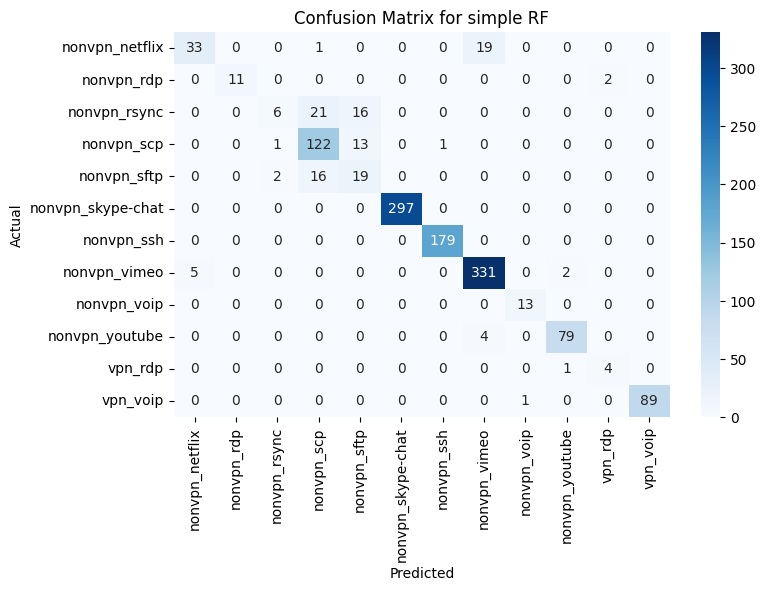

In [31]:
model = "simple RF"
cm = confusion_matrix(y_test, y_pred_simple)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"Confusion Matrix for {model}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

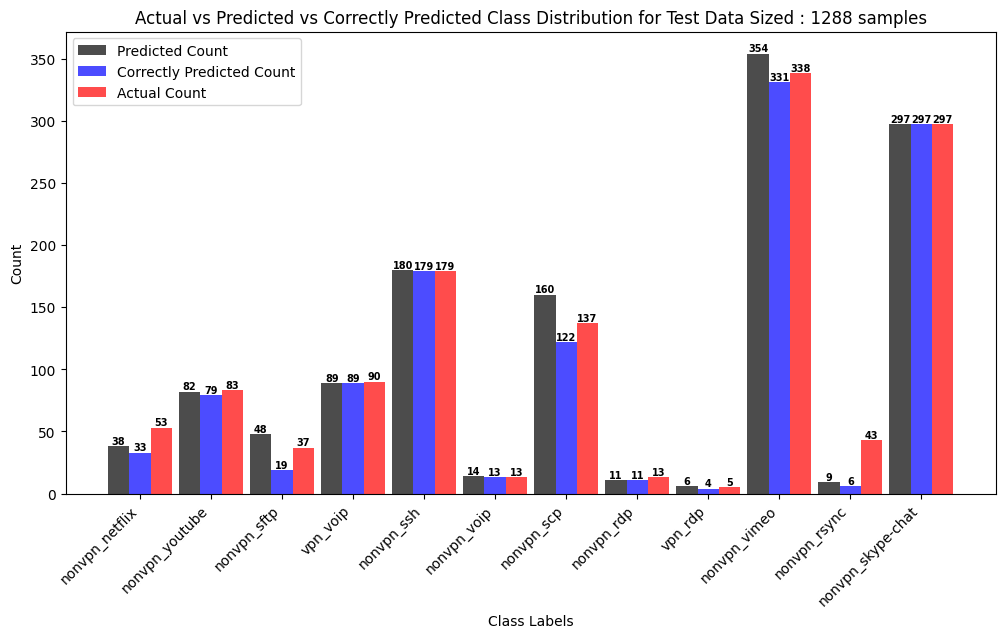

In [32]:
# Mapping encoded labels to class names
label_mapping_inv = {i: label for i, label in enumerate(le.classes_)}

# class distribution
unique_actual, counts_actual = np.unique(y_test, return_counts=True)    # Actual class distribution
unique_pred, counts_pred = np.unique(y_pred_simple, return_counts=True) # Predicted class distribution

# Convert numbers to class labels
actual_labels = [label_mapping_inv[i] for i in unique_actual]
predicted_labels = [label_mapping_inv[i] for i in unique_pred]

# Ensure all labels are present (even if missing in predictions)
all_labels = sorted(set(actual_labels) | set(predicted_labels), key=lambda x: x if x in label_mapping_inv else float('inf'))

# Convert to dictionary for alignment
actual_counts_dict = dict(zip(actual_labels, counts_actual))
predicted_counts_dict = dict(zip(predicted_labels, counts_pred))

# Fill missing classes with zero count
actual_counts = [actual_counts_dict.get(label, 0) for label in all_labels]
predicted_counts = [predicted_counts_dict.get(label, 0) for label in all_labels]

# Count correctly predicted samples for each class (True Positives)
true_positives = {label: 0 for label in all_labels}  # Initialize all as 0

for actual, pred in zip(y_test, y_pred_simple):
    if actual == pred:  # Correct prediction
        class_label = label_mapping_inv[actual]
        true_positives[class_label] += 1

# Convert true positives to a list for plotting
true_positive_counts = [true_positives.get(label, 0) for label in all_labels]

# Bar width and positions
x = np.arange(len(all_labels))  # Positions for bars
width = 0.3  # Width of bars

# Plot
plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width, predicted_counts, width, label="Predicted Count", color="black", alpha=0.7)
bars2 = plt.bar(x, true_positive_counts, width, label="Correctly Predicted Count", color="blue", alpha=0.7)
bars3 = plt.bar(x + width, actual_counts, width, label="Actual Count", color="red", alpha=0.7)

# Add text labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=7, fontweight='bold')

# Labels and Title
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title(f'Actual vs Predicted vs Correctly Predicted Class Distribution for Test Data Sized : {len(y_test)} samples')
plt.xticks(ticks=x, labels=all_labels, rotation=45, ha='right')  # Rotate x-labels for better readability
plt.legend()
plt.show()

In [36]:
# Cross-validation for Random Forest
rf_cv = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cv.fit(X_train, y_train)

# Perform 10-fold cross-validation and get accuracy scores
cv_scores = cross_val_score(rf_cv, features, labels, cv=10, scoring='accuracy')

# Print the accuracy for each fold and the average accuracy
print(f"Cross-validation accuracies: {cv_scores}")
print(f"\nAverage cross-validation accuracy: {np.mean(cv_scores):.2f}")

Cross-validation accuracies: [0.78837209 0.88578089 0.8974359  0.91608392 0.91841492 0.92540793
 0.92074592 0.94405594 0.95337995 0.95337995]

Average cross-validation accuracy: 0.91


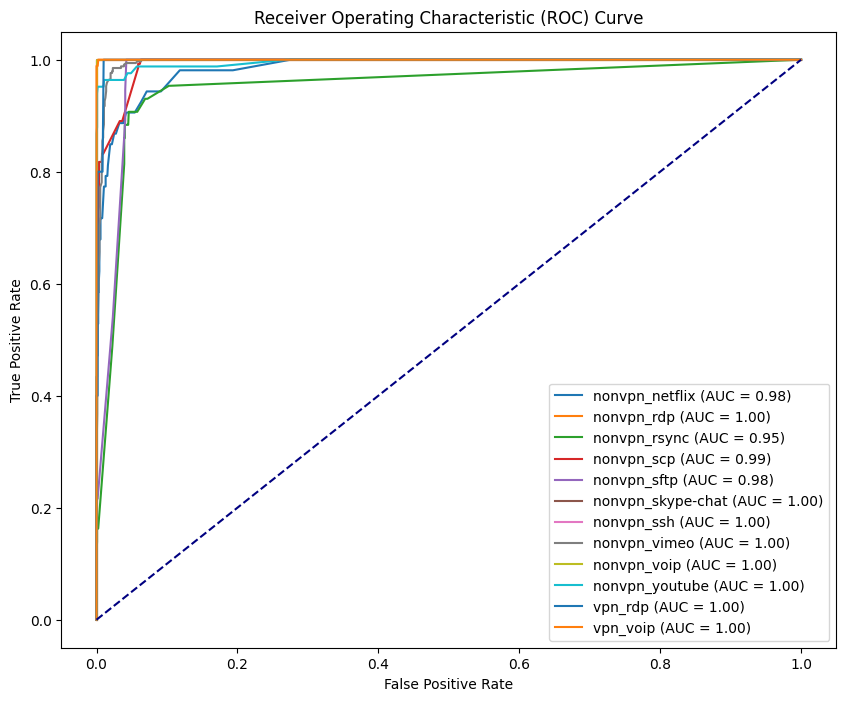

In [35]:
# Binarize the labels for multi-class ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))  # Binarize the actual test labels
y_pred_prob = rf_cv.predict_proba(X_test)  # Get predicted probabilities for each class

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)  # Calculate AUC for the class
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

# Plotting the ROC curve (diagonal line)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Labels and Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Part 3: Comparison with a deep learning-based model

In this part, you will compare your model with the DeepPacket model in terms of accuracy, explainability, and system cost. You can download a pre-trained DeepPacket model (pre-trained on the same dataset) using this [link](https://github.com/munhouiani/Deep-Packet). There is also featurized data available on the same link which you can use directly.  

Specifically, you should compare your trained model with the DeepPacket model in the following terms: 
- **Accuracy**: Compare the accuracy of the two models. Are there classes where one model is doing significantly better than the other?
- **Explainability**: conduct an explainability analysis of the two models. For instance, you could do a simple feature importance analysis if you are using decision tree for the first model. For DeepPacket, please use TRUSTEE to figure out the most important features and check which part of the packet (payload, TCP, TCP options etc.) do these correspond. 
- **System cost**: Analyze the runtime complexity of the model. Do this only for testing and NOT training. 


## Report here
Write your report here

In [ ]:
"""
    Accuracy Comparison:
    1. Simple RF: 0.92
    2. RF with 10-fold CV: 0.91
    3. Deep Packet: 0.95 (not shown here)

    System cost:
    

    Runtime-Complexity:
    1. Simple RF: O(n log n) (low cost)
    2. Deep Packet: O(n^2) (high cost)

"""

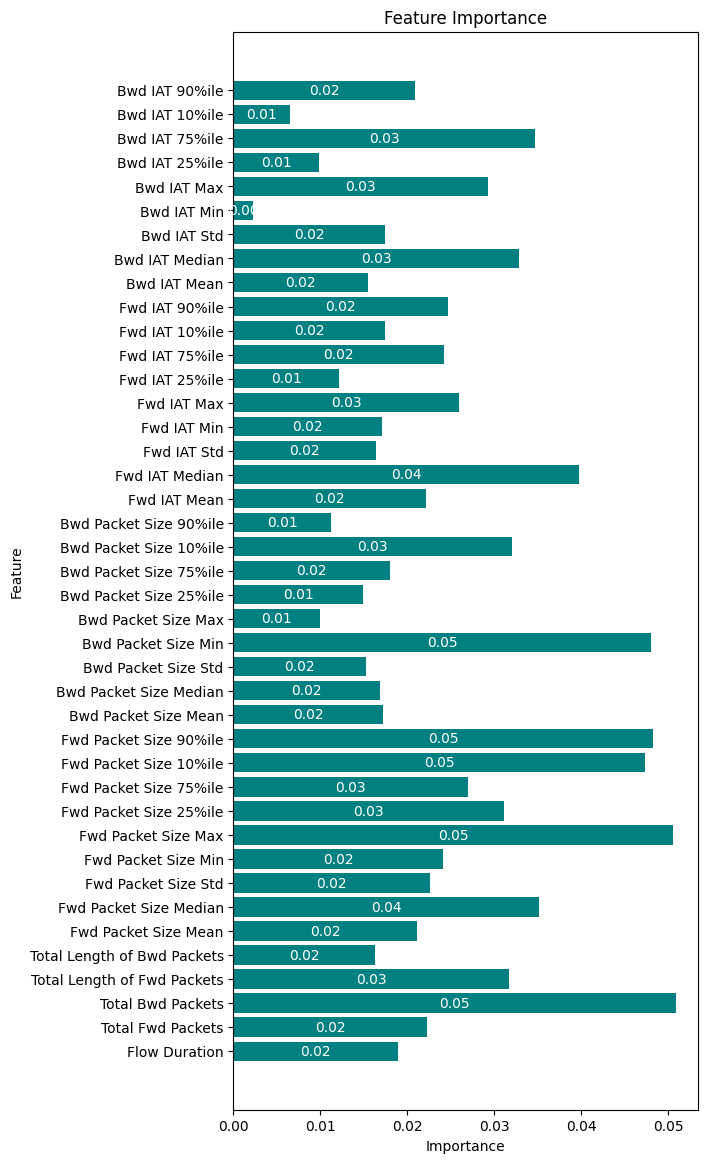

In [ ]:
# Plot for Feature Importance - RF model
importances = rf.feature_importances_
feature_names = features.columns

plt.figure(figsize=(6, 14))
bars = plt.barh(feature_names, importances, color='teal')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
for bar in bars:
    plt.text(bar.get_width() / 2,                               # X position (center of the bar)
             bar.get_y() + bar.get_height() / 2,                # Y position (center)
             f'{bar.get_width():.2f}',                          # Display importance value
             ha='center', va='center', fontsize=10, color='white')  
    
plt.show()